# Visualize Results: Impute Performance - "Fully Observed" Experiment

This notebook should answer the questions: *Which imputer works best to re-construct missing values?*

## Notebook Structure 

* Application Scenario 1 - Imputation Performance 
   * Categorical  Columns (Classification)
   * Numerical Columns (Regression)
   * Heterogenous Columns (Classification and Regression Combined)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns

from pathlib import Path
from data_imputation_paper.experiment import read_experiment, read_csv_files
from data_imputation_paper.plotting import plot_metric_vs_missing_fraction, plot_rank_vs_fraction_by_type, draw_cat_box_plot

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Settings

In [2]:
sns.set(style="whitegrid")
sns.set_context('paper', font_scale=1.5)
mpl.rcParams['lines.linewidth'] = '2'

In [3]:
EXPERIMENT = "fully_observed"

EXPERIMENT_PATH = Path(f"../data/experiments/{EXPERIMENT}/")

IMPUTE_RESULT_TYPE = "impute_performance_mean"
FIGURES_PATH = Path("../paper/figures/")

CLF_METRIC = "Categorical Columns"
REG_METRIC = "Numerical Columns"

CONFIDENCE_INTERVAL = 90

## Import the data

In [4]:
%%time

results = read_csv_files(read_experiment(EXPERIMENT_PATH), read_details=False)
results.head()

CPU times: user 1min 25s, sys: 4.28 s, total: 1min 30s
Wall time: 1min 39s


,experiment,imputer,task,missing_type,missing_fraction,strategy,column,result_type,metric,train,test,baseline,corrupted,imputed
0,fully_observed,AutoKerasImputer,40922,MAR,0.01,single_all,gyro_y,impute_performance_std,MAE,1.179853,1.120607,NaN,NaN,NaN
1,fully_observed,AutoKerasImputer,40922,MAR,0.01,single_all,gyro_y,impute_performance_std,MSE,23.152042,10.959723,NaN,NaN,NaN
2,fully_observed,AutoKerasImputer,40922,MAR,0.01,single_all,gyro_y,impute_performance_std,RMSE,1.425468,0.630841,NaN,NaN,NaN
3,fully_observed,AutoKerasImputer,40922,MAR,0.30,single_all,gyro_y,impute_performance_std,MAE,0.905889,0.471882,NaN,NaN,NaN
4,fully_observed,AutoKerasImputer,40922,MAR,0.30,single_all,gyro_y,impute_performance_std,MSE,13.756370,17.497516,NaN,NaN,NaN


In [5]:
impute_results = results[
    (results["result_type"] == IMPUTE_RESULT_TYPE) & 
    (results["metric"].isin(["F1_macro", "MAE"]))
]
assert len(results["strategy"].unique()) == 1
impute_results.drop(["experiment", "train", "strategy", "baseline", "corrupted", "imputed"], axis=1, inplace=True) 
impute_results = impute_results.rename(
    {
        "imputer": "Imputation Method",
        "task": "Task",
        "missing_type": "Missing Type",
        "missing_fraction": "Missing Fraction",
        "column": "Column",
        "test": "Imputation"
    },
    axis = 1
)

In [6]:
rename_imputer_dict = {
    "ModeImputer": "Mean/Mode",
    "KNNImputer": "$k$-NN",
    "ForestImputer": "Random Forest",
    "AutoKerasImputer": "Discriminative DL",
    "VAEImputer": "VAE",
    "GAINImputer": "GAIN"    
}

rename_metric_dict = {
    "F1_macro": CLF_METRIC,
    "MAE": REG_METRIC
}

impute_results = impute_results.replace(rename_imputer_dict)
impute_results = impute_results.replace(rename_metric_dict)

impute_results.head()

,Imputation Method,Task,Missing Type,Missing Fraction,Column,result_type,metric,Imputation
14904,Discriminative DL,40922,MAR,0.01,gyro_y,impute_performance_mean,Numerical Columns,6.209320
14907,Discriminative DL,40922,MAR,0.30,gyro_y,impute_performance_mean,Numerical Columns,6.018131
14910,Discriminative DL,40922,MAR,0.50,gyro_y,impute_performance_mean,Numerical Columns,7.044668
14913,Discriminative DL,40922,MAR,0.10,gyro_y,impute_performance_mean,Numerical Columns,5.350668
14916,Discriminative DL,40922,MCAR,0.01,gyro_y,impute_performance_mean,Numerical Columns,5.445196


## Compute Imputer Ranking

In [7]:
EXPERIMENTAL_CONDITIONS = ["Task", "Missing Type", "Missing Fraction", "Column", "result_type", "metric"]

clf_row_idx = impute_results["metric"] == CLF_METRIC
reg_row_idx = impute_results["metric"] == REG_METRIC

In [8]:
impute_results.loc[clf_row_idx, "Imputation Rank"] = impute_results[clf_row_idx].groupby(EXPERIMENTAL_CONDITIONS).rank(ascending=False, na_option="bottom", method="min")["Imputation"]
impute_results.loc[reg_row_idx, "Imputation Rank"] = impute_results[reg_row_idx].groupby(EXPERIMENTAL_CONDITIONS).rank(ascending=True, na_option="bottom", method="min")["Imputation"]
impute_results

,Imputation Method,Task,Missing Type,Missing Fraction,Column,result_type,metric,Imputation,Imputation Rank
14904,Discriminative DL,40922,MAR,0.01,gyro_y,impute_performance_mean,Numerical Columns,6.209320,4.0
14907,Discriminative DL,40922,MAR,0.30,gyro_y,impute_performance_mean,Numerical Columns,6.018131,2.0
14910,Discriminative DL,40922,MAR,0.50,gyro_y,impute_performance_mean,Numerical Columns,7.044668,2.0
14913,Discriminative DL,40922,MAR,0.10,gyro_y,impute_performance_mean,Numerical Columns,5.350668,1.0
14916,Discriminative DL,40922,MCAR,0.01,gyro_y,impute_performance_mean,Numerical Columns,5.445196,1.0
...,...,...,...,...,...,...,...,...,...
29793,GAIN,1220,MCAR,0.10,keyword_id,impute_performance_mean,Numerical Columns,NaN,6.0
29796,GAIN,1220,MNAR,0.01,keyword_id,impute_performance_mean,Numerical Columns,NaN,6.0
29799,GAIN,1220,MNAR,0.30,keyword_id,impute_performance_mean,Numerical Columns,NaN,6.0
29802,GAIN,1220,MNAR,0.50,keyword_id,impute_performance_mean,Numerical Columns,NaN,6.0


### Robustness: check which imputers yielded `NaN` values

In [10]:
for col in impute_results.columns:
    na_sum = impute_results[col].isna().sum()
    if na_sum > 0:
        print("-----" * 10)        
        print(col, na_sum)
        print("-----" * 10)        
        na_idx = impute_results[col].isna()
        print(impute_results.loc[na_idx, "Imputation Method"].value_counts(dropna=False))
        print("\n")

--------------------------------------------------
Imputation 276
--------------------------------------------------
GAIN                 273
Discriminative DL      3
Name: Imputation Method, dtype: int64




## Application Scenario 1 - Imputation Performance

In [11]:
impute_results.groupby(["metric"]).size()

metric
Categorical Columns     648
Numerical Columns      4320
dtype: int64

The data is not equally distributed between categorical and numerical imputation tasks, so simply averaging the ranks, as done in the plots below, could be misleading.

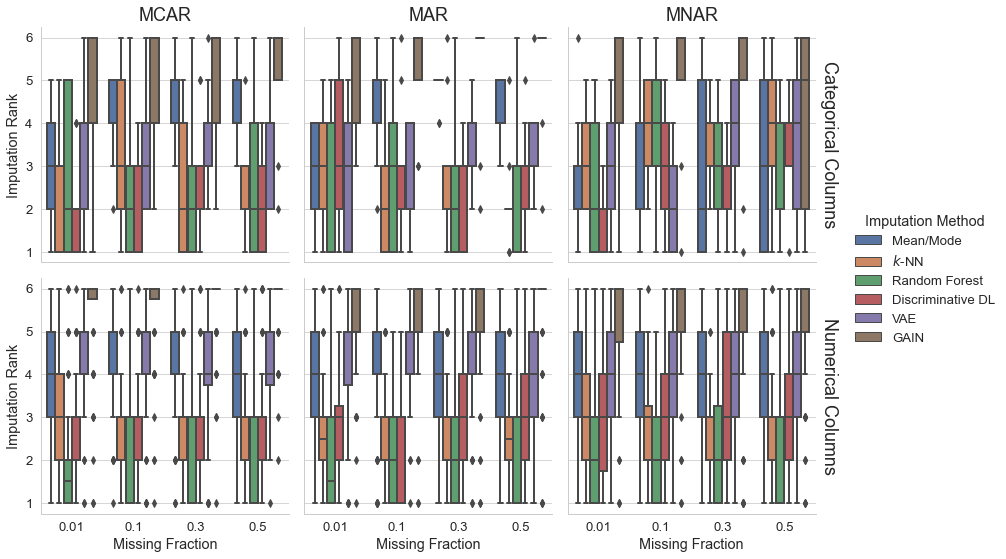

In [12]:
draw_cat_box_plot(
    impute_results,
    "Imputation Rank",
    None,
    FIGURES_PATH,
    "fully_observed_impute_rank_boxplot.eps",
    hue_order=list(rename_imputer_dict.values()),
    row_order=list(rename_metric_dict.values())
)